---
title: "Vancouver's Data Scientists"
output:
  html_notebook: default
  html_document: default
---

I'm going to try and webscrape LinkedIn for information on Vancouver's current data scientist opportunities. 




My original introduction into beautiful soup came from: https://www.analyticsvidhya.com/blog/2015/10/beginner-guide-web-scraping-beautiful-soup-python/
and
https://www.crummy.com/software/BeautifulSoup/bs4/doc/


Part 1. is focused on the current job market. 

I am going to get a list of links for current data scientist (and related) jobs in Vancouver. 

Then I'll go through each job posting and extract key information. What I think this will be at the beginning is something like: title, company, when it was posted, skills. Different companies phrase these different, but there is usually a list of requirements and then bonus items (nice-to-haves). 

First, let's get the postings I'm looking for. 


I manually pull up this link using the search for 
https://www.linkedin.com/jobs/search/?keywords=data%20scientist&location=Vancouver%2C%20British%20Columbia%2C%20Canada

If you inspect the link you can see the search terms I used (data scientist) and the location (Vancouver, BC).

I also can see that they show about 25 posting per 'page' with future pages having the '&start=' tag at the end:
https://www.linkedin.com/jobs/search/?keywords=data%20scientist&location=Vancouver%2C%20British%20Columbia%2C%20Canada&start=175



In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from urllib.request import Request, urlopen
import time
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait # available since 2.4.0
from selenium.webdriver.support import expected_conditions as EC # available since 2.26.0
import random

In [ ]:
#jobs_pages
jobs_page = "https://www.linkedin.com/jobs/search/?keywords=data%20scientist&location=Vancouver%2C%20British%20Columbia%2C%20Canada&sortBy=DD"

In [ ]:
job_urls = [] #Create empty list to store each job url in
driver = Chrome() #Set up a chrome driver (opens a browser that is controlled remotely)
driver.get(jobs_page) 
time.sleep(3) #Allows job page to load
more_jobs_path = '/html/body/main/section[1]/button' #There is a button at the bottom of the screen that 'loads more jobs'
for i in range(1,6):
    #print(i) #I like to print outputs in these loops to make sure everything is still running
    try:
        element = WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.XPATH, more_jobs_path)))
        jobs_button = driver.find_elements_by_xpath(more_jobs_path)[0]
        jobs_button.click()
        time.sleep(3) #Allows job page to load after pressing the button
    except:
        pass
    print("No more buttons to push") #When there are no more jobs to load, we have the full list of jobs loaded
mydivs = driver.find_elements_by_class_name("result-card__full-card-link") #This is the class name that has each individual job posting
for div in mydivs:
    job_url = div.get_attribute("href")
    job_urls.append(job_url) #add each job url to the list I created at the beginning. 
    #print(job_url) 

In [1]:
len(job_urls) #How many jobs do we have here?


NameError: name 'job_urls' is not defined

Often the information is stored in bulleted lists (\< li >), but in this first page we can see that there is a bulleted list for 'Essential skills' and 'Assets'. 

While it might be messier, I might have to grab all the description information (\< section class="description" >) for each page and sift through later. 


In [ ]:
#company_result = soup.find_all("a", class_="topcard__org-name-link")

#company = str(company_result)
#company = company.split(">")[1]
#company = company.split("<")[0]

#I realized I should write a function for this instead of copy and pasting. 

def return_string(soup_result):
    text = str(soup_result)
    text = text.split(">")[1]
    text = text.split("<")[0]
    return(text)

#return_string(company_result)
#return_string(title_result)


In [ ]:
#clean description
#After looking at it, there's going to be so much variability between them that this'll be a challenge. 
import re
def clean_description(description_result):
    description_text = str(description_result)
    description_text = re.sub('<[^<]+?>'," ", description_text)
    description_text = re.sub('  '," ", description_text)
    return(description_text)




In [ ]:
job_output = [] #Blank list that stores each job result
for job_url in job_urls:
    #print(job_url) #You can uncomment this if you want to make sure it is progressing through the web pages
    
    time.sleep(random.randint(10,100)/100) #I generally put in a random time-delay to not overload servers and not get banned
    try: 
        req = Request(job_url, headers= {'User-Agent': 'Mozilla/5.0'})
        page = urlopen(req).read()
        soup = BeautifulSoup(page, "html.parser") #I use a beautiful soup parser this time, because I find it easier to work with the results
        
        #Get raw results
        title_result = soup.find_all("h1")
        company_result = soup.find_all("a", class_="topcard__org-name-link")
        description_result = soup.find_all("section", class_="description")
        
        #Clean results using functions I created above
        title = return_string(title_result)
        company = return_string(company_result)
        description = clean_description(description_result)
        
        #Compile results into dictionary
        job_info = {
            'title': title,
            'company': company,
            'url' : job_url,
            'description' : description,
            'description_raw': str(description_result)
        }
        
        #Delete results after storing in dictionary so they are not re-used between job postings.
        del description_result 
        del title_result
        del company_result
        
        #Append dictionary to list
        job_output.append(job_info)
    except:
        pass

In [ ]:
#job_output #Very long text! 

Let's see what our data looks like 


In [ ]:
#job_output

jobs_df = pd.DataFrame(job_output)
jobs_df = jobs_df.sort_values("company")
#jobs_df["description"] = str(jobs_df["description"])
jobs_df["description"] = jobs_df["description"].astype(str) 
#del jobs_df["url"]
jobs_df = jobs_df.drop_duplicates()

#jobs_df["description"]

In [ ]:
#Write results:
jobs_df.to_csv("linkedin_data.csv", index=False)

#I write the results to a file to a) store the data, and b) be able to pick up here for working on this later

Alright, we've got our dataset of jobs with the rough description text. 

I reload these packages here so I can work from the 'finished' version, and don't have to webscrape everytime I want to update the analysis 


In [1]:

import pandas as pd
import numpy as np
jobs_df = pd.read_csv("linkedin_data.csv")
#jobs_df

Some of the most important parts I'd like to get out are the frequency of skills in the 'Requirements' and 'Assets' lists in each job posting. Unfortunately, they all use different language for these. I'm going to try and write a function that returns all the list entries after an initial word and stores the entries and the starting word for a job_id. 


In [2]:
#list_starters = ["Required Skills And Experience", "Must have", "Qualifications"]

requirements = ["Qualifications", "Requirements", "Required Skills And Experience", "Background", "background includes",  "Skills", "Needs", "Basic Qualifications", "Must Have"]
responsibilities = ["Responsibilities", "Your Role Is To", "What’s the job?"]
assets = ["Assets", "Additional skills", "Charm Us With", "Preferred Qualifications", "Additional", "Bonus", "we'd love to see you have"]


false_list = [False] * len(requirements)


In [3]:
#example_text = jobs_df.iloc[1,3]
#example_text

def remove_escape_chars(text):
        text = text.replace("-", "")
        text = text.replace("[", "")
        text = text.replace("{", "")
        text = text.replace("(", "")
        return(text)

#return_list function returns the list that follows a certain word. 
#Job description often have list sections (e.g., Requirements: list)
def return_list(text, list_starters):
    jobs_quals = []
    
    text = text.lower()
    list_starters = [x.lower() for x in list_starters]
    
    split_list = text.split("<li>") #Split each list element into its own text.
    text = remove_escape_chars(text)
    text = remove_escape_chars(text)#Need to run twice because of "--"
    false_list = [False] * len(list_starters)
    for i in range(0,len(split_list)):
        text = split_list[i]
        if [x in text for x in list_starters] != false_list:
            y = [x in text for x in list_starters]
            #print(y)
            list_starter = np.array(list_starters)[np.array(y)]
            list_starter = str(list_starter[0])
            
            #Create a list and store each 'qualification' in it
            job_quals = []
            for n in range(i+1, len(split_list)):           
                if "</li>" in split_list[n]:
                    qual = split_list[n]
                    qual = qual.split("</li>")[0]
                    job_quals.append(qual)
                    #print("List item")
            #Define output as a dictionary with the qualification type and the qualifications
            job_dict = {list_starter : job_quals}
            jobs_quals.append(job_dict)
    return(jobs_quals)
    

#return_list(example_text, list_starters=requirements)

In [4]:
jobs_df["Requirements"] = jobs_df["description_raw"].apply(return_list, list_starters=requirements)
jobs_df["Responsibilities"] = jobs_df["description_raw"].apply(return_list, list_starters=responsibilities)
jobs_df["Assets"] = jobs_df["description_raw"].apply(return_list, list_starters=assets)

jobs_df["Requirements"].astype(str).str.find("qualifications")

#jobs_df
for n in range(1, len(jobs_df)):
    if len(jobs_df.loc[n, "Requirements"]) > 0:        
        if len(jobs_df.loc[n, "Assets"]) > 0:
            for i in range(0, len(jobs_df.loc[n, "Requirements"])):
                req_dict = jobs_df.loc[n, "Requirements"][i].values()
                for x in range(0, len(jobs_df.loc[n, "Assets"])):
                    asset_dict = jobs_df.loc[n, "Assets"][x].values()
                    if asset_dict==req_dict:
                        print("1")
            
                
    


Extract information from these:


In [5]:
jobs_df["Requirements"] = jobs_df["Requirements"].astype(str) 
jobs_df["Requirements"] = jobs_df["Requirements"].str.lower()
jobs_df["Assets"] = jobs_df["Assets"].astype(str) 
jobs_df["Assets"] = jobs_df["Assets"].str.lower()
jobs_df["Responsibilities"] = jobs_df["Responsibilities"].astype(str) 
jobs_df["Responsibilities"] = jobs_df["Responsibilities"].str.lower()


In [6]:
def job_attribute(df, colname, search_column, search_string=None):
    z = pd.Series(0, index=jobs_df.index)
    if search_string==None:
        search_string = colname
    if type(search_string)==str:
        z = jobs_df[search_column].str.find(search_string)
    if type(search_string)==list:
        for x in search_string:    
            y = jobs_df[search_column].str.find(x)
            z = z + y
    df[colname] = z  
    del z 
    df[colname] = df[colname].apply(lambda x: 1 if x >0 else 0)
    return(df)

jobs_df["All"] = jobs_df["Requirements"].astype(str)  + jobs_df["Assets"].astype(str) 

jobs_df["All"] = jobs_df["All"].str.lower()

#simple searches just use the lower case text to search. Must be fairly unique
simple_searches = ["bigquery", "python", "sql", "jira", "tableau", "docker", "scala", "java", "spark", "hadoop",
                  "statistics", "nlp", "cnn", "rnn", "programming"]
cols = ["Requirements", "Assets"]

for col in cols:
    for search in simple_searches:
        job_attribute(df=jobs_df, colname=search+"_"+col, search_string=search, search_column=col)

#Complex searches wouldn't necessarily work, and would return a lot of false positives 
#E.g., 'r' would return every posting that has an 'r' in it. 
complex_searches = {
    "R": [" r,", " R or"],
    "bachelor" : ["bachelor", "bs/ms"],
    "master" : ["master", "bs/ms", " ms ", "graduate degree"],
    "phd" : ["phd","ph\.d" "graduate degree"],
    "C":  ["c\+", "c\+\+", "c#"],
    "ML": [" ml", "machine learning"],
    "CS":  ["computer science", " cs"],
    "SAS": [" sas ", " sas,", " sas\."],
    "AI": [" ai ", " ai,", "ai "]
}

#This for loop goes through each of the complex searches dictionary items 
#It creates a column based on the dictionary key, and uses the values as the search string
for col in cols:
    for search in complex_searches:
        job_attribute(df=jobs_df, colname=search+"_"+col, search_string=complex_searches[search], search_column=col)

#I have to clean the data for where a masters or phd degree appears in both the requirements and assets
jobs_df["master_Assets"].loc[jobs_df["master_Requirements"]==1] = 0
jobs_df["phd_Assets"].loc[jobs_df["phd_Requirements"]==1] = 0


#jobs_df["graduate_edu_all"] = 0 
#jobs_df["graduate_edu_all"].loc[jobs_df["master_all"]==1] = 1
#jobs_df["graduate_edu_all"].loc[jobs_df["phd_all"]==1] = 1

#Then I want to look at posting that require and graduate education or any university education
jobs_df["graduateEducation_Requirements"] = 0 
jobs_df["graduateEducation_Requirements"].loc[jobs_df["master_Requirements"]==1] = 1
jobs_df["graduateEducation_Requirements"].loc[jobs_df["phd_Requirements"]==1] = 1

jobs_df["university_Requirements"] = 0 
jobs_df["university_Requirements"].loc[jobs_df["master_Requirements"]==1] = 1
jobs_df["university_Requirements"].loc[jobs_df["phd_Requirements"]==1] = 1
jobs_df["university_Requirements"].loc[jobs_df["bachelor_Requirements"]==1] = 1

#jobs_df

/Users/Tim/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
skills_summary = jobs_df.iloc[:, 10:len(jobs_df.columns)]
skills_summary = skills_summary.melt()
skills_summary = skills_summary.groupby('variable', as_index=False).sum()

skills_summary_df = pd.DataFrame(skills_summary)

skills_summary_df["variable"] = skills_summary_df["variable"].astype(str)
new_col = skills_summary_df["variable"].str.split(pat='_', expand=True)
skills_summary_df["attribute"] = new_col[0]
skills_summary_df["type"] = new_col[1]

#skills_summary_df.columns = ["variable", "value"]


skills_summary_df

,variable,value,attribute,type
0,AI_Assets,2,AI,Assets
1,AI_Requirements,4,AI,Requirements
2,CS_Assets,8,CS,Assets
3,CS_Requirements,37,CS,Requirements
4,C_Assets,1,C,Assets
5,C_Requirements,4,C,Requirements
6,ML_Assets,12,ML,Assets
7,ML_Requirements,32,ML,Requirements
8,R_Assets,4,R,Assets
9,R_Requirements,15,R,Requirements


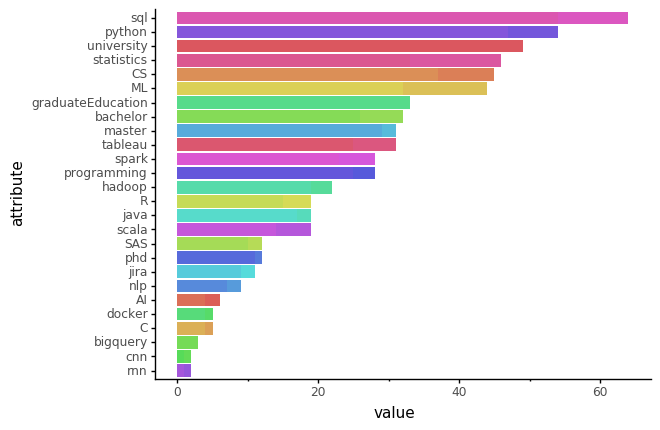

<ggplot: (-9223372036552306912)>

In [8]:
import plotnine as p9
#Set plot aesthetics:
p9.theme_set(p9.theme_classic())


def sort_df(df, var_col, val_col="value", ascending=False):
    if len(set(var_col))<len(df):
        df_temp = df.groupby(var_col, as_index=False).sum()
        var_ordered = df_temp[var_col][df_temp[val_col].sort_values(ascending=ascending).index.tolist()] 
    else:
        var_ordered = df[var_col][df[val_col].sort_values(ascending=ascending).index.tolist()]    
    df[var_col] = pd.Categorical(df[var_col], categories=list(reversed(list(var_ordered))), ordered=True)
    return(df)
skills_summary_df = sort_df(skills_summary_df, var_col="attribute")
skills_summary_df["type"] = pd.Categorical(skills_summary_df["type"])

skills_summary_df["type"] = skills_summary_df["type"].cat.reorder_categories(["Requirements", "Assets"])

(p9.ggplot(skills_summary_df, p9.aes('attribute', 'value', fill='variable')) + 
 p9.geom_col() +
 p9.coord_flip() +
 p9.scale_fill_discrete(guide=False)
)
#skills_summary_df["type"]



This graph above is real ugly, but it does show that our code is in general working

/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: lang_plot.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


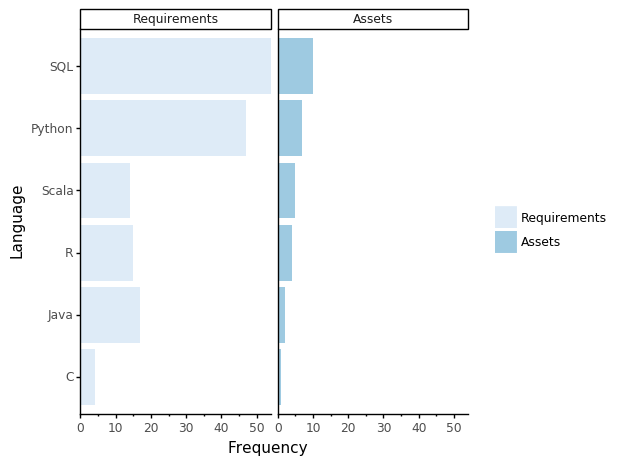

<ggplot: (304722226)>

In [15]:
#Languages
languages = ["R", "sql", "python", "java", "scala", "C", "sas"]

lang_clean = {"sql": "SQL",
             "python": "Python",
             "R": "R",
             "java": "Java",
             "scala": "Scala",
             "C": "C",
             "sas": "SAS"}

skills_summary_lang = skills_summary_df[skills_summary_df.attribute.isin(languages)]
skills_summary_lang = skills_summary_lang.replace(to_replace=lang_clean)
skills_summary_lang = sort_df(skills_summary_lang, var_col="attribute")


lang_plot = (p9.ggplot(skills_summary_lang, p9.aes('attribute', 'value', fill='type', show_legend=False)) + 
 p9.geom_col() + 
 p9.coord_flip() + 
 p9.scale_y_continuous(expand=[0,0]) + 
 p9.labs(y="Frequency", x="Language", fill="") +
 p9.scale_fill_brewer(palette="Blues") +
 p9.facet_wrap('~type')
)
lang_plot.save(filename = 'lang_plot.png', height=5, width=5, units = 'in', dpi=1000)
lang_plot

/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: soft_plot.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


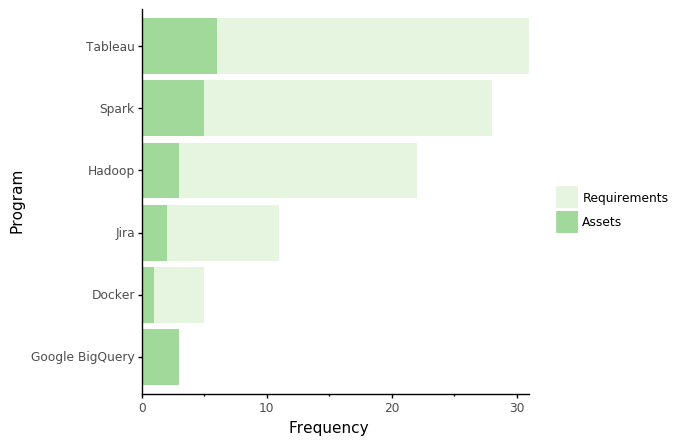

<ggplot: (-9223372036550033941)>

In [17]:

programs = ["tableau", "docker", "bigquery", "jira", "spark", "hadoop"]

prog_clean = {"tableau": "Tableau",
             "docker": "Docker",
             "bigquery": "Google BigQuery",
             "jira" : "Jira",
             "spark": "Spark",
             "hadoop": "Hadoop"}

skills_summary_prog = skills_summary_df[skills_summary_df.attribute.isin(programs)]
skills_summary_prog = skills_summary_prog.replace(to_replace=prog_clean)

skills_summary_prog = sort_df(skills_summary_prog, var_col="attribute")

soft_plot= (p9.ggplot(skills_summary_prog, p9.aes('attribute', 'value', fill='type', show_legend=False)) + 
 p9.geom_col() + 
 p9.coord_flip() + 
 p9.scale_y_continuous(expand=[0,0]) + 
 p9.labs(y="Frequency", x="Program", fill="") +
 p9.scale_fill_brewer(palette= "Greens")
)
soft_plot.save(filename = 'soft_plot.png', height=5, width=5, units = 'in', dpi=1000)
soft_plot


/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: edu_plot.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


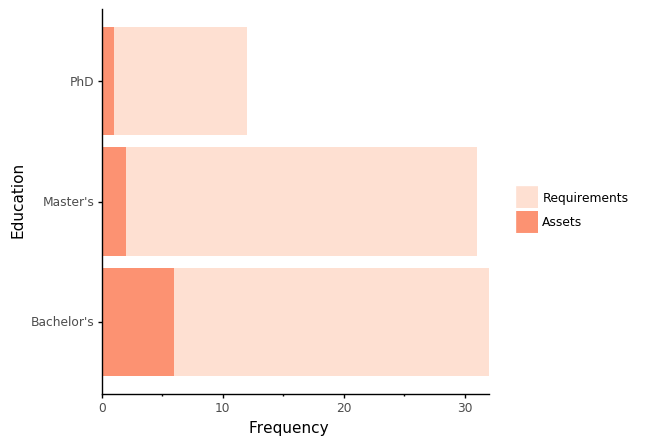

<ggplot: (-9223372036543083155)>

In [20]:
#Education basic

education = ["bachelor", "master", "phd"]

education_clean = {"bachelor": "Bachelor's",
             "master": "Master's",
             "phd": "PhD"}

skills_summary_edu = skills_summary_df[skills_summary_df.attribute.isin(education)]
skills_summary_edu = skills_summary_edu.replace(to_replace=education_clean)

edu_plot = (p9.ggplot(skills_summary_edu, p9.aes('attribute', 'value', fill='type', show_legend=False)) + 
 p9.geom_col() + 
 p9.coord_flip() + 
 p9.scale_y_continuous(expand=[0,0]) + 
 p9.labs(y="Frequency", x="Education", fill="") +
 p9.scale_fill_brewer(palette= "Reds")
)
edu_plot.save(filename = 'edu_plot.png', height=5, width=5, units = 'in', dpi=1000)
edu_plot

/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: know_plot.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


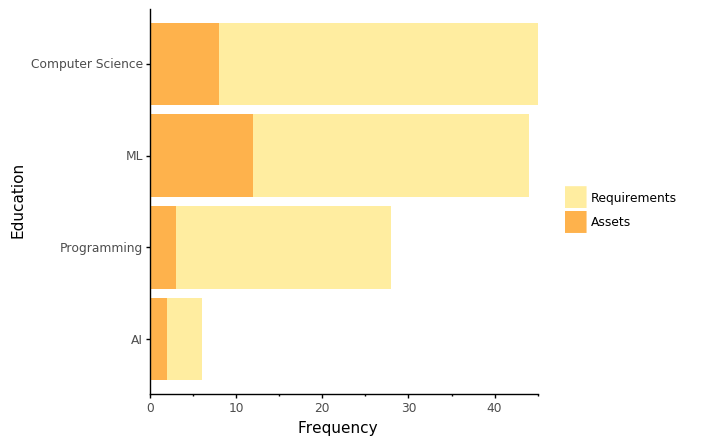

<ggplot: (311747676)>

In [21]:

knowledge = ["CS", "AI", "stats", "programming", "ML"]

knowledge_clean = {"AI": "AI",
             "CS": "Computer Science",
             "stats": "Statistics",
                "programming": "Programming"}

skills_summary_know = skills_summary_df[skills_summary_df.attribute.isin(knowledge)]
skills_summary_know = skills_summary_know.replace(to_replace=knowledge_clean)
skills_summary_know = sort_df(skills_summary_know, var_col="attribute")

know_plot = (p9.ggplot(skills_summary_know, p9.aes('attribute', 'value', fill='type', show_legend=False)) + 
 p9.geom_col() + 
 p9.coord_flip() + 
 p9.scale_y_continuous(expand=[0,0]) + 
 p9.labs(y="Frequency", x="Education", fill="") +
 p9.scale_fill_brewer(palette= "YlOrRd")
)
know_plot.save(filename = 'know_plot.png', height=5, width=5, units = 'in', dpi=1000)
know_plot

/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/Tim/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: niche_plot.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


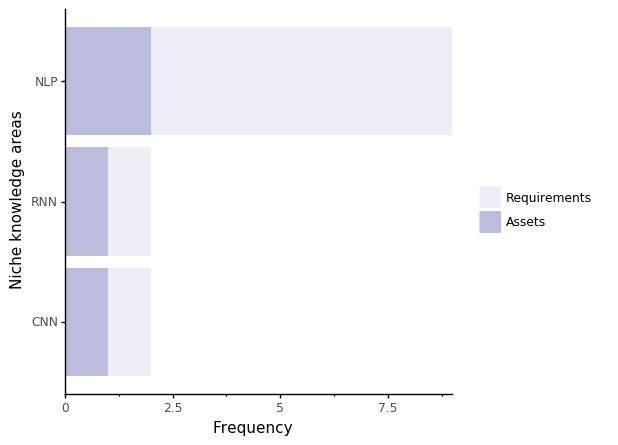

<ggplot: (302513058)>

In [22]:
niche = ["cnn", "rnn",  "nlp"]

niche_clean = {
             "cnn": "CNN",
             "rnn": "RNN",
                "nlp": "NLP"}
def sort_df(df, var_col, val_col="value", ascending=False):
    if len(set(df[var_col]))<len(df):
        df_temp = df.groupby(var_col, as_index=False).sum()
        var_ordered = df_temp[var_col][df_temp[val_col].sort_values(ascending=ascending).index.tolist()] 
    else:
        var_ordered = df[var_col][df[val_col].sort_values(ascending=ascending).index.tolist()]    
    df[var_col] = pd.Categorical(df[var_col], categories=list(reversed(list(var_ordered))), ordered=True)
    return(df)

skills_summary_niche = skills_summary_df[skills_summary_df.attribute.isin(niche)]
skills_summary_niche = skills_summary_niche.replace(to_replace=niche_clean)
skills_summary_niche = sort_df(skills_summary_niche, var_col="attribute")

niche_plot = (p9.ggplot(skills_summary_niche, p9.aes('attribute', 'value', fill='type', show_legend=False)) + 
 p9.geom_col() + 
 p9.coord_flip() + 
 p9.scale_y_continuous(expand=[0,0]) + 
 p9.labs(y="Frequency", x="Niche knowledge areas", fill="") +
 p9.scale_fill_brewer(palette="Purples")
)
niche_plot.save(filename = 'niche_plot.png', height=5, width=5, units = 'in', dpi=1000)
niche_plot

Mistakes I made:
- I originally didn't sort the job postings by some feature (i.e., by date and so 'relevance' could change over time)
- My original code was only giving me job postings from one page even though I was looping over multiple. When I test the links individually, they worked. I fixed this by switching to selenium and not trying to go to the new pages as separate requests but by loading more jobs on their infinite scroll system.
- I had to go back to redefine some functions to make sure they were returning the right information, and I wanted to know more about where the information (e.g., skill, language or topic area) was coming from in the job posting. 
- Probably lots more. 


Other things that I could do:
1. Analyze by industry or domain 
1. Match up these jobs with estimated salaries from Glass Door
